# Apply Neural Networks to the Stock Market

Notebook to explore limited set of NY stock exchange data over around 40 years, as part of the Portland Data Science group (Mar 2018).
Data selected by Matt Borthwick from Yahoo! Finance.
Working with Neural Network group: Matt, John Burt, Manny, Isil, Kenny, Jhoan, Mark C.

Our goal is to predict weekly returns on 6 industry based ETFs, as well
as aggregate market performance (such as Russel3000).  We will also
be using some macroeconomic indicators as well.
This notebook currently loads the data, transforms it, and applies a
simple neural network to try predicting the next days stock prices.

The plan is to train on this data (up to Sep 2017),
validate on (Oct-Dec 2017), and test in final session on (Jan-Mar 2018).

(For more exploratory screwing around, and other attempts at time-series see PDX_finance1)

# Google Colab setup

First up however, we need to install modules to load up our google drive for storage.  (Code taken from this helpful post https://medium.com/deep-learning-turkey/google-colab-free-gpu-tutorial-e113627b9f5d)
(Code and commands didn't look sketchy/malicious, but I didn't examine the PPA too closely either.)

This code is for execution inside a Jupyter notebook on colab.google.com.
It gives Colab access to your Google Drive in order to load/save data from within the notebook.
Colab has most popular libraries (numpy, pandas, tensorflow, matplotlib).  I'm not sure how extensive it is.

I've found opening a jupyter notebook on google drive automatically opens the Colab.

In [ ]:
#Install modules on local machine.
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!echo 'past update'
!apt-get -y install -qq google-drive-ocamlfuse fuse
!echo 'installed fuse'

In [ ]:
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
print('past first command')
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

In [ ]:
#Mounts google drive, and changes to that directory
!mkdir -p drive 
!google-drive-ocamlfuse drive

import os
os.chdir("drive")

#Should now be in the root of your google-drive, and now free to load/save existing files.

# Load Libraries and Data

Now to load libraries, and data.  (This is where I start my analysis
                                   on my home machine.)

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
# automatically reload files.
%load_ext autoreload
%autoreload 2

In [3]:
#Data compiled from Yahoo! Finance data by Matt Borthwick
df=pd.read_csv('data/stocks-us-adjClose.csv',index_col=0,parse_dates=True)
df.index.name='Time'

In [5]:
df.head()

                  ED        DD       CVX        FL       CAT        IP  SJW  \
Time                                                                          
1970-01-02  0.307997  0.000480  0.582503  1.857836  1.475225  1.808415  NaN   
1970-01-05  0.320831  0.000481  0.585290  1.839623  1.470783  1.873423  NaN   
1970-01-06  0.316553  0.000477  0.576929  1.845694  1.435234  1.855694  NaN   
1970-01-07  0.312275  0.000475  0.575535  1.809266  1.390800  1.814324  NaN   
1970-01-08  0.312275  0.000469  0.586683  1.821408  1.395244  1.832054  NaN   

             F  LLY  AVP ...   EXTN  VYGR  ACG  MIME  TCRZ  MCX  EDIT  LMHA  \
Time                     ...                                                  
1970-01-02 NaN  NaN  NaN ...    NaN   NaN  NaN   NaN   NaN  NaN   NaN   NaN   
1970-01-05 NaN  NaN  NaN ...    NaN   NaN  NaN   NaN   NaN  NaN   NaN   NaN   
1970-01-06 NaN  NaN  NaN ...    NaN   NaN  NaN   NaN   NaN  NaN   NaN   NaN   
1970-01-07 NaN  NaN  NaN ...    NaN   NaN  NaN   Na

# Neural Network

This model is just a test based purely on the stock data.
The network uses a multi-layer RNN, with two hidden layers at input/output.  They use leaky ReLU activation.
The model currently plays with 100 stocks from 2002-2006.

This uses a model I've cobbled together in Tensorflow.
The OO structure is borrowed from the online problem sets
from CS224 on NLP offered in 2017 at Stanford.
The NN is borrowed from A. Geron "Hands on Machine Learning with Scikit-Learn and Tensorflow", which I've found to be the best
overall introduction, and has a good mix of background, and code.
(Note there is an associated Github account with code).

The Tensorflow docs were pretty hard reading, and there seem to be lots
of tricks that only practitioners on StackOverflow are aware of.  (But the tutorials are pretty readable.)


In [4]:
import tensorflow as tf
from recurrent_network import recurrent_NN

# Data Transformation

For the initial testing, I'm just building a model based on the 100 oldest stocks (or whichever come first), and looking at 2002-2006.
Why then?  Because it looks relatively well behaved.
The model is trained on the first half of the data, and we then run the
network on the whole data set.  

I'm currently just taking the base-10 log of the data, and scaling each
stock to lie with [-1,1].  I found differencing the data lead to
pretty crappy results.

So there's some choices to be played with here:
- scaling: variance vs max/min
- differencing?

In [6]:

Nstocks=100
Xsub=df.loc['2002':'2006'].iloc[:,:Nstocks].values

#set missing values to zero.  (to avoid issues in network with NaNs)
Xsub[np.isnan(Xsub)]=0

#take differences of logs. (shift zero to avoid NANs)
#Xsub2 = np.diff(np.log10(Xsub+1E-12),axis=0)
Xsub2 = np.log10(Xsub+1E-12)

Xsub_max = np.max(Xsub2,axis=0)
Xsub_min = np.min(Xsub2,axis=0)

#Choice of scaling here: max/min vs variance?
#I think variance makes more sense if differencing.
rng = 0.5*(Xsub_max-Xsub_min)
avg = 0.5*(Xsub_max+Xsub_min)
Xsub2= (Xsub2-avg)/rng

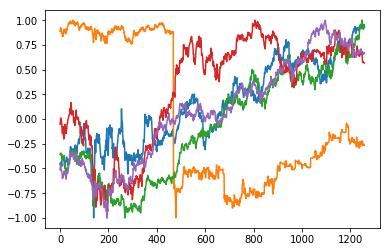

In [7]:
#check scaling
plt.figure()
plt.plot(Xsub2[:,0:5])
plt.show()

In [8]:
#define network.
#Note a lot of network parameters are defined in __init__ in "recurrent_network.py".
#A more robust structure would pass a config dict or something like that.
RNN=recurrent_NN(60,Nstocks,100,Nstocks,'GRU')

iter #200. Current MSE:0.006282703019678593
Total Time taken:111.33165669441223




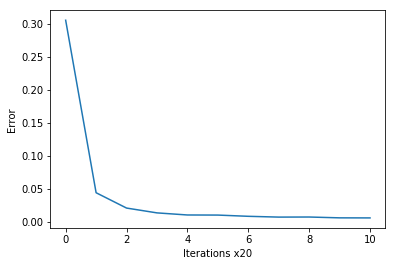

In [9]:
#Rebuild the tensorflow graph.
RNN.build()
#Actually train the graph on first half of data.
#Give all of the data to this subroutine, where it selects
# the inputs and target data in get_random_batch

N=len(Xsub2)
Nc=int(N/2)
Xtrain = Xsub2[:Nc]
RNN.train_graph(Xtrain,Xtrain,save_name='tf_models/rnn_test')
#Note the tiny, tiny errors.  Probably badly overfitting.
#Need to fix the dropout so it's only on in training.

In [10]:
#Predict on all of the data.
#This loads up a previous model.
RNN_pred=RNN.predict_all('tf_models/rnn_test',200,Xsub2,reset=True)

INFO:tensorflow:Restoring parameters from tf_models/rnn_test-200
0 100
100 200
200 300
300 400
400 500
500 600
600 700
700 800
800 900
900 1000
1000 1100


In [11]:
def plot_pred(X,pred,indx_range):
    """Plots a particular stock and the prediction"""

    plt.figure()
    plt.subplot(121)
    plt.plot(X[:,indx_range])
    plt.plot(pred[:,indx_range])
    plt.plot([len(X)/2]*2,[-1,1],'k-')
    plt.legend(['Actual','Forecast'])
    plt.title('Raw')

    plt.subplot(122)
    plt.plot(np.cumsum(X[:,indx_range],axis=0))
    plt.plot(np.cumsum(pred[:,indx_range],axis=0))
    plt.legend(['Actual','Forecast'])    
    plt.title('Cumulative')

    plt.show()
    

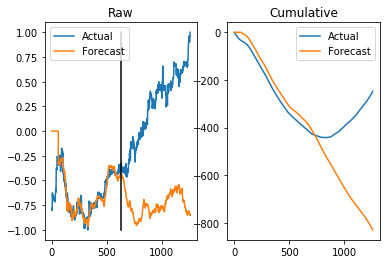

In [17]:
#Could make predicted results a time series for nicer formating, and dates.
#Plot cumulative for cases when we've also differenced.
plot_pred(Xsub2,RNN_pred,50)

This RNN forecast is also WAY worse than a persistence forecast (tomorrow's price is the same as todays).
Big question: why is the price wandering away? Even if the model is fixed (weights unchanged), surely it should take the recent past (which the model uses to forecast tomorrow's demand) into account.  

Note the effect of further smoothing, which suggests a clearer trend, that might be easier to model.
That suggests the convolutional networks may be useful,
perhaps with running averages to smooth the data.  Forecasting on a week timescale might allevative some of that too?

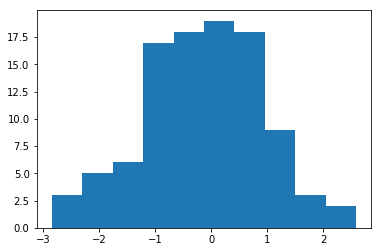

In [13]:
#Let's look at the differences between the predicted and actual
#results at the end of the period.
pred_diff=RNN_pred[-1]-Xsub2[-1]
plt.hist(pred_diff)
plt.show()

In [15]:
(np.mean(pred_diff),np.std(pred_diff))

(-0.1433746024133806, 1.0660086500156463)

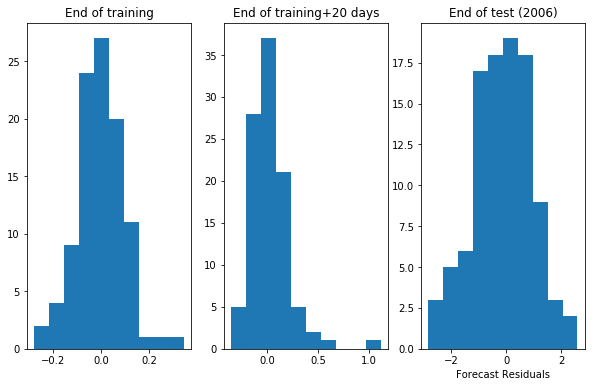

In [16]:
#Let's now see how much the predictions vary (across all stocks) at the end of training, 20 trading days after that,
# and at the end of the period, a year or two out.

#Note that these predictions use the data from those periods, but the model is not being updated.

Nc = int(len(Xsub2)/2)
plt.figure(figsize=(10,6))
plt.subplot(131)
pred_diff=RNN_pred[Nc]-Xsub2[Nc]
plt.title('End of training')
plt.hist(pred_diff)


plt.subplot(132)
pred_diff=RNN_pred[Nc+20]-Xsub2[Nc+20]
plt.title('End of training+20 days')
plt.hist(pred_diff)

plt.subplot(133)
pred_diff=RNN_pred[-1]-Xsub2[-1]
plt.hist(pred_diff)
plt.title('End of test (2006)')
plt.xlabel('Forecast Residuals')
plt.show()


The final graph is worst, it is also trying to predict many years ahead, based on essentially short-term info.
Probably could describe build up of cumulative errors as a random walk?
Would guess errors grows as sqrt(T), so the variance of this distribution grows as T.



In [190]:
#Checking my batching was finding the right things.
#Looks plausible.
xi,yi=RNN.get_random_batch(Xsub2,Xsub2)

In [206]:
batch_no=1
stock_no=1
print(xi[batch_no,-10:,stock_no])
print(yi[batch_no,stock_no])

[ 0.86257978  0.88103946  0.86054468  0.87236487  0.87699467  0.8733055   0.88605149  0.8815979   0.89817284  0.91405475]
0.906092957954
